# Climate Model Package Tutorial

Climate science has experienced a large growth in interest over the past several decades, especially with regards to changing climate trends like temperature, weather patterns, and sea levels. This package allows the user to do parameter estimation and model comparison using Bayesian inference. While only a few models are supported in the package, the user is capable of modifying the source code to add new models with minimal effort.

## Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data IO and modeling packages:

In [2]:
# Modules for climate model analysis
from climate import data_io
from climate.inference import model

## Example data

The data against which we compare our model is a timeseries of global **temperature anomaly** averages. Begin by calling `get_example_data_file_path`, which takes as input the name of the file and the location of the data file (the `data/` directory is the default) and returns the location of the file.

In [3]:
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')

Now we call `load_data_temp`, which takes the file location as input and returns a Pandas data frame containing temperature data. Note that this function's behavior is specific to the format of the text file for temperature data obtained from the Berkeley group.

In [4]:
# Load data and obtain numpy arrays for data and uncertainty
data = data_io.load_data_temp(fileload)
year, temperature, tempUnc = data['year'], data['monthly_anomaly'], data['monthly_anomaly_unc']

We'll downsample the data and modify the uncertainties:

In [5]:
# Temperature data are recorded at monthly intervals, but we will 
# downsample to match the (yearly) resolution of the emissions files
year = year.values[0::12]
temperature = temperature.values[0::12]
# Uncertainties in the data files correspond to 95% CL (2-sigma), 
# divide these values by 2 to obtain 68% CL (1-sigma)
tempUnc = tempUnc.values[0::12] / 2

Now we will plot the temperature anomaly and errorbars obtained from the data file:

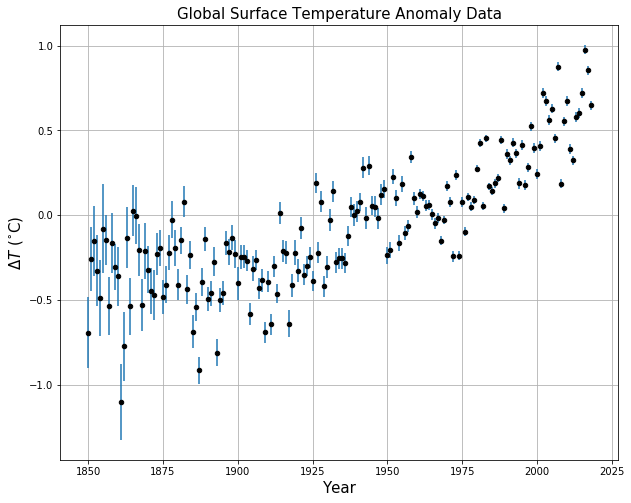

In [6]:
# We can plot temperature anomaly vs. time
plt.figure(figsize=(10,8))
plt.errorbar(year, temperature, tempUnc, linestyle='none')
plt.scatter(year, temperature, c='k', zorder=5, s=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('$\Delta T$ ($^{\circ}$C)', fontsize=15)
plt.title('Global Surface Temperature Anomaly Data', fontsize=15);
plt.grid()

Now that the data is read in, we can do parameter estimation on a model. We use the package `pySCM`, which is a simple model for temperature change that uses emissions curves for 4 green house gases. We use a modified version of this model with 5 parameters: overall temperature shift (to exchange between temperature change and anomoly), and 4 overall normalization factors for the emissions curves. This model is called `ModifiedSimpleClimateModel`. The user can create an instance of this model and offer the data as input to the constructor:

In [7]:
# Create Modified Simple Climate Model instance
SCM = model.ModifiedSimpleClimateModel(year, temperature, tempUnc)

Next, the user should set the priors on the model parameters. Each instance of `Model` (superclass of `ModifiedSimpleClimateModel`) has as a field an array of `ndim` instances of `Prior`, each of which can be called once initialized. To see this in action, we initialize the model priors by giving it an array of length `ndim` containing strings of the prior type (uniform, guassian, or jeffreys) and two arrays containing the 2 parameters of the prior. For simplifity, we use uniform priors:

In [8]:
# Set priors on parameters
prior_type = [ 'uniform','gaussian','gaussian','gaussian','gaussian' ]
prior_param1 = [-1.0, 1.0, 1.0, 1.0, 1.0]
prior_param2 = [ 1.0, 0.1, 0.1, 0.1, 0.1]
SCM.set_priors(prior_type, prior_param1, prior_param2)

Now we can call each of these priors and check that they give the expected distribution. To obtain a particular prior (which can be called as a function), call `SCM.priors`, which is an array, so `SCM.priors[i]` is the prior of the $i^\text{th}$ parameter of the model:

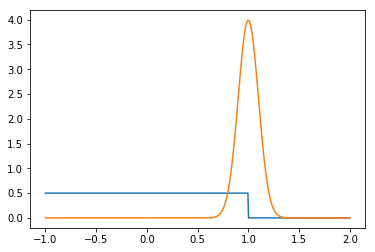

In [9]:
# Test that priors are working as expected
test_x = np.linspace(-1, 2, 500)
test_prior_1 = [ np.exp(SCM.priors[0](tx)) for tx in test_x ]
test_prior_2 = [ np.exp(SCM.priors[1](tx)) for tx in test_x ]
plt.plot(test_x, test_prior_1)
plt.plot(test_x, test_prior_2)

Note that these distributions are normalized to unity.

Now that the model and its priors are initialized, we can run a Markov-Chain Monte Carlo algorithm implemented by the package `emcee`. To do this, create an array of initial guesses of the model parameters. Then call `run_MCMC` with this array, the number of walkers to use, and the number of steps for each walker:

In [10]:
# Run MCMC on the model
paramGuess = [-0.4, 1., 1., 1., 1.]
%time SCMsample = SCM.run_MCMC(paramGuess, nwalkers=10, nsteps=400)

Progress: 
[################################################################################]

CPU times: user 4min 5s, sys: 559 ms, total: 4min 5s
Wall time: 4min 5s


The user can then call `show_results` on the model with the number of initial steps to skip (burn-in). The function displays a histogram and kernel-density for each of the parameters (marginalized over all others). The data and best-fit for the model are plotted together. The best-fit values reported are the medians and the intervals are the 16$^\text{th}$ and 84$^\text{th}$ percentiles.

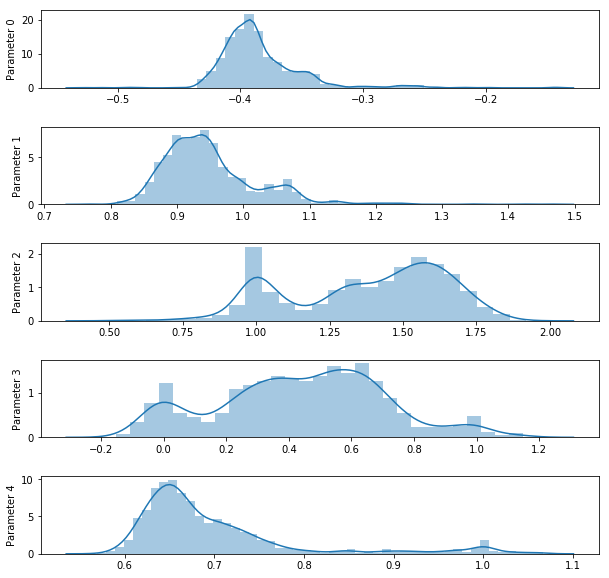

Param 0 = -0.391237 + 0.032395 - 0.018791
Param 1 = 0.935881 + 0.080226 - 0.048274
Param 2 = 1.436240 + 0.206580 - 0.426110
Param 3 = 0.454458 + 0.225319 - 0.316229
Param 4 = 0.668299 + 0.079582 - 0.036884


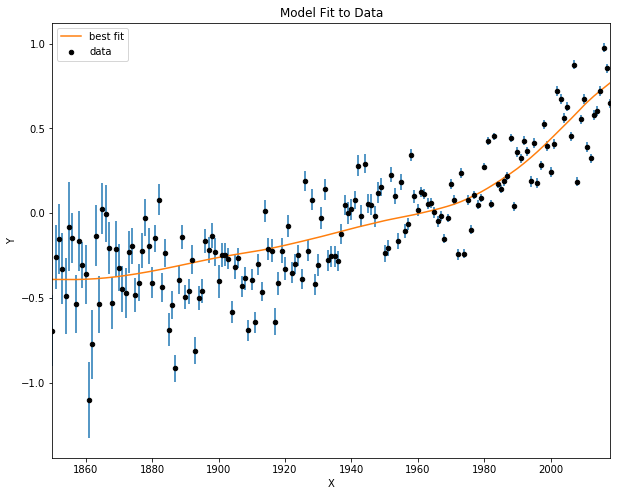

In [11]:
# Plot results from the sampling
SCM.show_results(burnin=100)

We also have a class `BasicCloudSeedingModel`, which is a 2-parameter model for cloud seeding based off of solar activity data. In particular, we use solar flare index as the input for our model. Again, we use `data_io` to read in the data in the same fashion as before and generate a plot of the data:

In [12]:
# Cloud Seeding Model, plot of flare data
fileload = data_io.get_example_data_file_path(
    'flare-index_total_*.txt', data_dir='data/flares')
data_flares = data_io.load_data_flare(fileload, verbose=0)

In [13]:
# Get np.arrays for data series
years_flares = data_flares['years'].values
flares = data_flares['flares_index_mean'].values
flares_unc = data_flares['flares_index_unc'].values

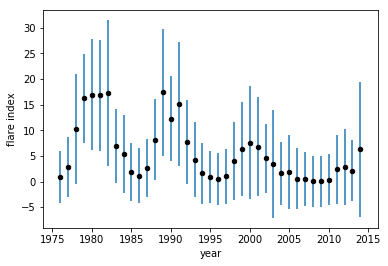

In [14]:
#Plot the data
plt.errorbar(years_flares, flares, flares_unc,  linestyle='none')
plt.scatter(years_flares, flares, c='k', zorder=5, s=20, label='data')
plt.xlabel('year')
plt.ylabel('flare index');

The simple model for cloud seeding is the following:
$$ \Delta T_i = \alpha \times  a_{\rm sun, i-i_{lag}}, $$
where $\alpha$ is a normalization constant, $i_{\rm lag}$ is a index offset corresponding to the time lag between the seeding of clouds and the impact on temperature, and $a_{\rm sun, i}$ is the $i^\text{th}$ data point of solar activity.
Using these solar flare data, let's create an instance of <code>BasicCloudSeedingModel</code> from the <code>model</code> package; it takes as input the temperature data (first three parameter fields) and the solar data (last two parameters).

In [15]:
# Test Cloud Seeding Model
CSModel = model.BasicCloudSeedingModel(year, temperature, tempUnc, years_flares, flares, flares_unc)

As described above, the cloud seeding model has two parameters, $\alpha$ and $t_{\rm lag}$, so we set priors for these parameters as before:

In [16]:
# Set priors on parameters
# param2 is placeholder for poisson since it only needs one parameter
prior_type = ['uniform', 'poisson' ]
prior_param1 = [-0.5, 1]
prior_param2 = [ 0.5, -1]
CSModel.set_priors(prior_type, prior_param1, prior_param2)

What if ALL variation in global temperature were a result of cloud seeding?  This is unreasonable, but we can still assume this is the case and compute best-fit parameters:  

In [17]:
# Run MCMC on the cloud seeding model
paramGuess = [0, 0]
%time CSModelSample = CSModel.run_MCMC(paramGuess, nwalkers=50, nsteps=500)

/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Progress: 
[################################################################################]

CPU times: user 5.47 s, sys: 1.11 s, total: 6.58 s
Wall time: 5.44 s


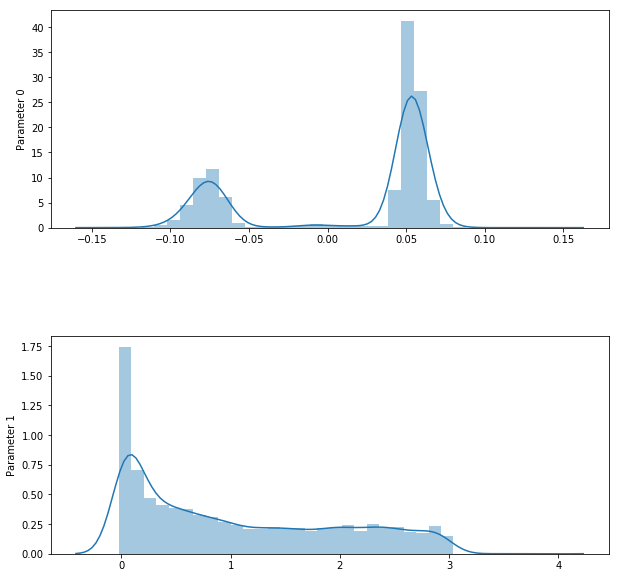

Param 0 = 0.049949 + 0.008263 - 0.125283
Param 1 = 0.768244 + 1.489008 - 0.710065


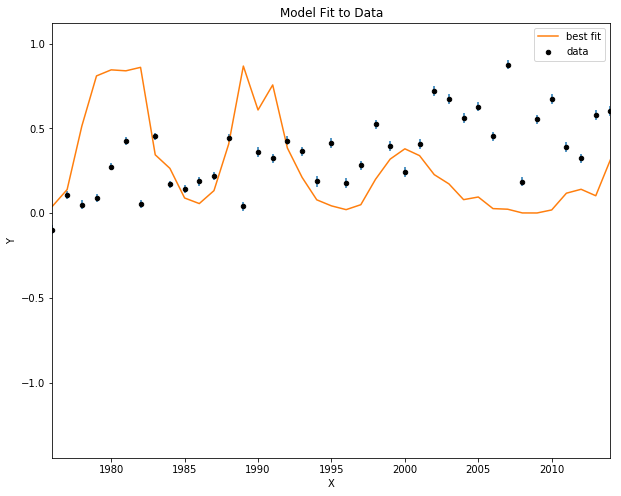

In [18]:
# Plot results from the sampling
CSModel.show_results(burnin=100)

So far, we've defined a simple climate model, and also a basical cloud seeding model.  We can use the <code>CombinedModel</code> class to merge the two models, and perform parameter estimation on the models. To do this, we again make arrays for the priors (this time there are 7 total parameters), create an instance of `CombinedModel` that takes as input the models to combine, and then we call `set_priors` as before:

In [22]:
# Initialize CombinedClimateModel and its priors
prior_type = ['uniform','gaussian','gaussian','gaussian','gaussian','uniform','poisson']
prior_param1 = [-0.5, 1.0, 1.0, 1.0, 1.0, -0.5,  1]
prior_param2 = [ 0.5, 0.1, 0.1, 0.1, 0.1,  0.5, -1]
CombinedClimateModel = model.CombinedModel(SCM, CSModel)
CombinedClimateModel.set_priors(prior_type, prior_param1, prior_param2)

We then call `run_MCMC` on the combined model as before:

In [23]:
# Run MCMC on combined model
paramGuess = [-0.4, 1.,1.,1.,1., 0., 1.]
%time combined_model_sample = CombinedClimateModel.run_MCMC(paramGuess, nwalkers=14, nsteps=350)

Progress: 
[################################################################################]

CPU times: user 6min 24s, sys: 1.82 s, total: 6min 26s
Wall time: 6min 26s


And as before, we can show the results of the algorithm using `show_results`:

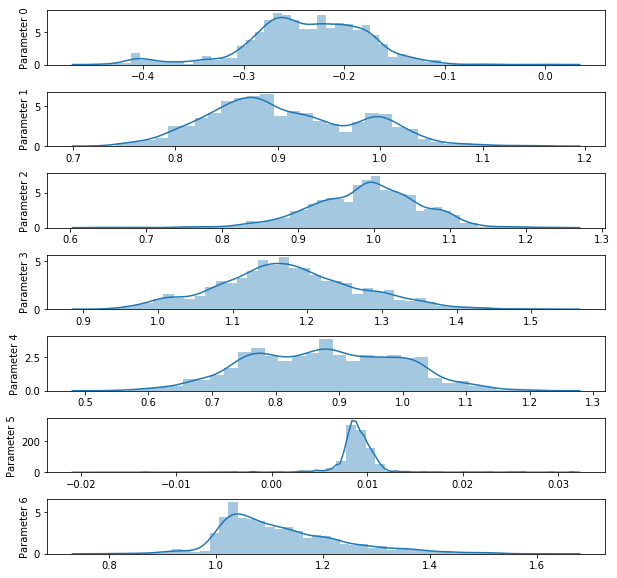

Param 0 = -0.235423 + 0.055932 - 0.049308
Param 1 = 0.893919 + 0.101348 - 0.057491
Param 2 = 0.993827 + 0.063049 - 0.073411
Param 3 = 1.169805 + 0.099582 - 0.084613
Param 4 = 0.878121 + 0.126167 - 0.123336
Param 5 = 0.008895 + 0.001436 - 0.001071
Param 6 = 1.096783 + 0.133913 - 0.073794


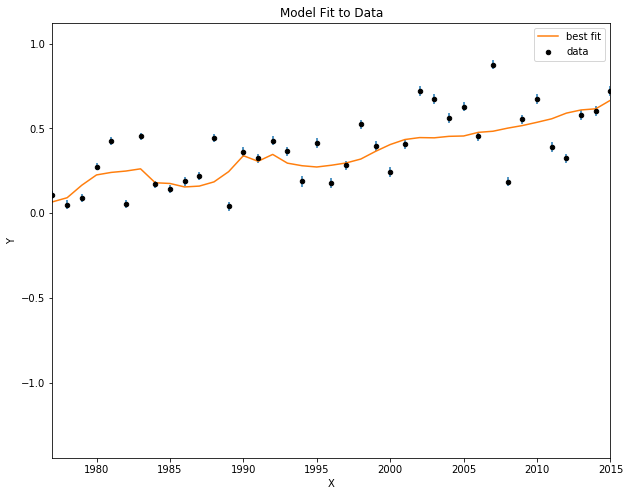

In [24]:
# Show the results of the MCMC algorithm
CombinedClimateModel.show_results(burnin=100)

# Generative model

Both the SCM and cloud seeding models are deterministic. There are two sources of uncertainties in our case - random noise in temperature measurement, and a model uncertainty originating from the uncertainty of solar data (the independent variable).

We use Gaussian models for both the random noise of temperature anomaly measurement and uncertainty of solar data, with one-sigma standard deviation being the widths of the Gaussians. This is because when we have no better information about the distribution of the errors except its width/spread, a Gaussian is the least commital (maximum entropy) choice, which avoids underestimating the uncertainty in the posterior.

For the purpose of this discussion we neglect the time lag parameter in the solar cloud seeding model and calculate the model uncertainty via $$\sigma_{z_i} = |dz_i/dx_i| \sigma_{x_i} = |\alpha| \sigma_{x_i}.$$ Thus we have 

$$P(Z_i|\theta, M)=  f_Z(z_i)= \frac{1}{\sqrt{2 \pi \alpha^2 \sigma_{{\rm sun},i}^2}}
 \exp\left(\frac{-(z_{i}- \alpha a_{{\rm sun},i})^2}{2 \alpha^2 \sigma_{{\rm sun},i}^2}\right).$$

For the random error of temperature measurement we have

$$P(E_i|\theta, M)=  f_E(y_i-z_i)= \frac{1}{\sqrt{2 \pi \sigma_{i}^2}}
 \exp\left(\frac{-e_{i}^2}{2 \sigma_{i}^2}\right).$$

The two sources of uncertainty are independent.

Now $p(Y_i|\theta, M)$ is the convolution of $f_Z(z_i)$ and $f_E(y_i-z_i)$. In the case where both functions are Gaussians, the convolution yields a particularly simple result for the $i^{\rm th}$ data point:

$$P(Y_i|\theta, M)=  \frac{1}{\sqrt{2 \pi (\sigma_{i}^2 + \alpha^2 \sigma_{{\rm sun},i}^2)}}
 \exp\left(\frac{-(y_{i}- \alpha a_{{\rm sun},i})^2}{2 (\sigma_{i}^2 + \alpha^2 \sigma_{{\rm sun},i}^2)}\right).$$

Also, we assume that the data points at different times are independent, so the likelihood function is a product of $p(Y_i|\theta, M)$ for all $Y_i$'s.


Development is ongoing and with it the writing of this tutorial!